In [63]:
import fitz

In [64]:
# 读取 PDF 并提取文本
def extract_text_from_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    text = ""
    for page_number in range(doc.page_count):
        page = doc[page_number]
        text += page.get_text() + "\n"
    doc.close()
    return text

# 你的 10-K 文件路径
pdf_2023 = "D:/rady/MGTF423/apple_10k_2023.pdf"
pdf_2024 = "D:/rady/MGTF423/apple_10k_2024.pdf"

# 解析文本
apple_reports = {
    "2023": extract_text_from_pdf(pdf_2023),
    "2024": extract_text_from_pdf(pdf_2024)
}

In [65]:
# 检查是否成功读取
for year, content in apple_reports.items():
    print(f"✅ Apple {year} 财报已加载，文本长度: {len(content)} 字符")

✅ Apple 2023 财报已加载，文本长度: 272868 字符
✅ Apple 2024 财报已加载，文本长度: 415889 字符


## 趋势分析

In [66]:
import re
import matplotlib.pyplot as plt
import pdfplumber
from textblob import TextBlob

## Sentiment Analysis

In [76]:
import pandas as pd
from pathlib import Path

class TechAttitudeAnalyzer:
    def __init__(self, pdf_path):
        self.pdf_path = Path(pdf_path)
        self.tech_keywords = {
            "GenAI": ["generative AI", "Apple Intelligence", "generative models"],
            "Spatial Computing": ["Vision Pro", "spatial computer", "visionOS"],
            "EV": ["electric vehicle", "EV", "autonomous driving"]
        }
        self.results = []

    def extract_tech_context(self):
        """提取包含技术关键词的上下文段落"""
        if not self.pdf_path.exists():
            raise FileNotFoundError(f"PDF文件 {self.pdf_path} 不存在")

        with pdfplumber.open(self.pdf_path) as pdf:
            for page_num, page in enumerate(pdf.pages, 1):
                text = page.extract_text()
                if not text:
                    continue
                
                sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
                for sent in sentences:
                    sent_clean = re.sub(r'\s+', ' ', sent).strip()
                    for tech, keywords in self.tech_keywords.items():
                        if any(re.search(rf"\b{re.escape(kw)}\b", sent_clean, re.IGNORECASE) for kw in keywords):
                            self.results.append({
                                "technology": tech,
                                "page": page_num,
                                "sentence": sent_clean,
                                "sentiment": self._analyze_sentiment(sent_clean),
                                "strategic_priority": self._detect_priority(sent_clean)
                            })

    def _analyze_sentiment(self, text):
        """情感分析（-1到1区间）"""
        analysis = TextBlob(text)
        return round(analysis.sentiment.polarity, 2)

    def _detect_priority(self, text):
        """战略优先级检测"""
        priority_keywords = {
            "high": ["critical", "strategic", "core", "invest heavily", "leadership", "breakthrough"],
            "medium": ["developing", "exploring", "potential", "alignment"],
            "low": ["monitoring", "evaluating", "no current plans", "requires ongoing"]
        }
        text_lower = text.lower()
        for level, keywords in priority_keywords.items():
            if any(re.search(rf"\b{kw}\b", text_lower) for kw in keywords):
                return level
        return "neutral"

    def generate_report(self):
        """生成分析报告（修复版）"""
        if not self.results:
            return {}

        df = pd.DataFrame(self.results)
        report = {
            tech: {
                "avg_sentiment": group['sentiment'].mean(),
                "priority_distribution": group['strategic_priority'].value_counts().to_dict(),
                "key_statements": group[['page', 'sentence']].head(3).to_dict('records')
            }
            for tech, group in df.groupby('technology')
        }
        return report

    def save_report(self, report, output_dir):
        """保存报告到文件"""
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        
        for tech, data in report.items():
            with open(output_dir / f"{tech.replace(' ', '_')}_report.txt", "w") as f:
                f.write(f"Technology: {tech}\n")
                f.write(f"Average Sentiment: {data['avg_sentiment']:.2f}\n")
                f.write(f"Priority Distribution: {data['priority_distribution']}\n")
                f.write("Key Statements:\n")
                for stmt in data['key_statements']:
                    f.write(f"- Page {stmt['page']}: {stmt['sentence']}\n")

if __name__ == "__main__":
    try:
        analyzer = TechAttitudeAnalyzer("D:/rady/MGTF423/apple_10k_2024.pdf")
        analyzer.extract_tech_context()
        report = analyzer.generate_report()
        
        # 打印结果
        print("技术态度分析报告\n" + "="*50)
        for tech, data in report.items():
            print(f"\nTechnology: {tech}")
            print(f"情感倾向均值: {data['avg_sentiment']:.2f}")
            print(f"战略优先级分布: {data['priority_distribution']}")
            print("关键陈述：")
            for stmt in data['key_statements']:
                print(f"  → P{stmt['page']}: {stmt['sentence']}")
        
        # 保存结果
        analyzer.save_report(report, "D:/rady/MGTF423/results")
        print("\n分析结果已保存至 D:/rady/MGTF423/results 目录")

    except Exception as e:
        print(f"错误发生: {str(e)}")

技术态度分析报告

Technology: GenAI
情感倾向均值: 0.00
战略优先级分布: {'neutral': 1}
关键陈述：
  → P24: Third Quarter 2024: • iPad Air; • iPad Pro; • iOS 18, macOS Sequoia, iPadOS 18, watchOS 11, visionOS 2 and tvOS 18, updates to the Company’s operating systems; and • Apple Intelligence™, a personal intelligence system that uses generative models.

Technology: Spatial Computing
情感倾向均值: 0.12
战略优先级分布: {'neutral': 2}
关键陈述：
  → P4: Apple Vision Pro™ is the Company’s first spatial computer based on its visionOS™ operating system.
  → P24: Third Quarter 2024: • iPad Air; • iPad Pro; • iOS 18, macOS Sequoia, iPadOS 18, watchOS 11, visionOS 2 and tvOS 18, updates to the Company’s operating systems; and • Apple Intelligence™, a personal intelligence system that uses generative models.
错误发生: 'gbk' codec can't encode character '\u2022' in position 31: illegal multibyte sequence


In [77]:
import re
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from PyPDF2 import PdfReader
import matplotlib.pyplot as plt

In [78]:
# 初始化情感分析器
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

def extract_text_from_pdf(pdf_path):
    """从PDF中提取文本（增强版）"""
    reader = PdfReader(pdf_path)
    text = ""
    for page in reader.pages:
        text += page.extract_text()
    # 标准化换行符和空格
    return re.sub(r'\s+', ' ', text).strip()

def analyze_product_sentiments(text):
    """精准分割产品段落"""
    # 使用更灵活的分割规则
    product_sections = re.split(
        r'\b(?:iPhone|Mac|iPad|Wearables|可穿戴设备)\b', 
        text, 
        flags=re.IGNORECASE
    )[1:]  # 丢弃第一个空元素
    
    product_data = {}
    current_product = None
    
    # 增强领域词汇权重
    sia.lexicon.update({
        'innovative': 2.5, 'flagship': 1.8, 
        'ultra': 1.7, 'pro': 1.5
    })
    
    for i, section in enumerate(product_sections):
        if i % 2 == 0:
            # 奇数索引为产品名称
            current_product = section.strip()
        else:
            # 偶数索引为描述内容
            if current_product:
                # 清洗文本
                clean_text = re.sub(r'[^a-zA-Z0-9\s®©™]', '', section)
                # 情感分析
                scores = sia.polarity_scores(clean_text)
                product_data[current_product] = {
                    'compound': scores['compound'],
                    'positive': scores['pos'],
                    'neutral': scores['neu'],
                    'negative': scores['neg']
                }
    return product_data

# 可视化函数保持不变（同之前代码）

if __name__ == "__main__":
    pdf_path = "D:/rady/MGTF423/apple_10k_2024.pdf"
    text = extract_text_from_pdf(pdf_path)
    
    # 调试：打印关键段落
    print("=== 提取的产品段落样例 ===")
    print(re.findall(r'(iPhone|Mac|iPad|Wearables).*?(?=\s\b(?:iPhone|Mac|iPad|Wearables)\b)', text, re.DOTALL)[0][:500])
    
    sentiment_results = analyze_product_sentiments(text)
    
    print("\n=== 分析结果 ===")
    print(f"{'产品':<10} | {'综合得分':<8} | {'积极':<6} | {'中性':<6} | {'消极':<6}")
    print("-"*45)
    for product, scores in sentiment_results.items():
        print(f"{product:<10} | {scores['compound']:.4f}   | {scores['positive']:.4f} | {scores['neutral']:.4f} | {scores['negative']:.4f}")
    

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\log\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


=== 提取的产品段落样例 ===
iPhone

=== 分析结果 ===
产品         | 综合得分     | 积极     | 中性     | 消极    
---------------------------------------------
and accessories, and sells a variety of related services. The Company’s fiscal year is the 52- or 53-week period that ends on the last Saturday of September. Products | 0.0000   | 0.0000 | 0.0000 | 0.0000
® is the Company’s line of smartphones based on its iOS operating system. The | 0.0000   | 0.0000 | 1.0000 | 0.0000
16 Pro,    | 0.0000   | 0.0000 | 1.0000 | 0.0000
15,        | 0.0000   | 0.0000 | 1.0000 | 0.0000
SE®.       | 0.0000   | 0.0000 | 0.0000 | 0.0000
® is the Company’s line of personal computers based on its macOS® operating system. The | 0.2732   | 0.1490 | 0.8510 | 0.0000
mini®,     | 0.0000   | 0.0000 | 1.0000 | 0.0000
Pro®.      | 0.0000   | 0.0000 | 0.0000 | 0.0000
® is the Company’s line of multipurpose tablets based on its iPadOS® operating system. The | 0.0000   | 0.0000 | 1.0000 | 0.0000
Pro®,      | 0.0000   | 0.0000 | 1.0000 | 0.0

In [79]:
def extract_product_name(full_name):
    """
    从完整的产品名称字符串中提取关键的产品名（如 iPhone, iPad, Mac 等）。
    这里假设产品名称是字符串中首个匹配的关键单词。
    """
    keywords = ["iPhone", "iPad", "Mac", "Wearables", "Accessories", "Services"]
    for keyword in keywords:
        if keyword.lower() in full_name.lower():
            return keyword
    return None  # 如果不匹配任何关键字，则返回 None

def visualize_sentiments(sentiment_results):
    """优化可视化的产品情感分析结果（仅保留关键 product 名称，有数据的才显示，负向情感的横坐标改为 iPhone and iPad(Greater China)）"""

    # 提取产品名称和情感分数
    product_names = list(sentiment_results.keys())
    compound_scores = [sentiment_results[p]["compound"] for p in product_names]

    # **过滤掉没有数据的项**
    filtered_data = [(name, score) for name, score in zip(product_names, compound_scores) if score != 0]
    if not filtered_data:
        print("没有有效的数据可视化")
        return

    product_names, compound_scores = zip(*filtered_data)

    # **提取关键产品名称**
    simplified_labels = [extract_product_name(name) for name in product_names]

    # **处理负向情感的横坐标名称**
    for i in range(len(compound_scores)):
        if compound_scores[i] < 0:
            simplified_labels[i] = "iPhone and iPad(Greater China)"

    # **调整图像尺寸**
    plt.figure(figsize=(12, 6))

    # **绘制条形图**
    bars = plt.bar(range(len(product_names)), compound_scores, width=0.6, 
                   color=['#4CAF50' if s > 0 else '#D32F2F' for s in compound_scores], 
                   edgecolor="black", alpha=0.9)

    # **设置横坐标标签**
    plt.xticks(range(len(product_names)), simplified_labels, rotation=30, ha="right", fontsize=10)

    # **设置标题和标签**
    plt.xlabel("")  # 不显示横坐标名称
    plt.ylabel("Sentiment Score", fontsize=12)
    plt.title("Product Sentiment Analysis Results", fontsize=14, fontweight="bold")

    # **自动调整布局，防止文字被截断**
    plt.tight_layout()

    # **标注负向情感数值**
    for bar, score in zip(bars, compound_scores):
        plt.text(bar.get_x() + bar.get_width()/2, score + (0.05 if score > 0 else -0.05), 
                 f'{score:.2f}', ha='center', va='bottom' if score > 0 else 'top', 
                 fontsize=10, color='black', fontweight="bold")

    # **增加 y 轴网格**
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # **修正 y 轴范围**
    plt.ylim(min(compound_scores) - 0.1, max(compound_scores) + 0.1)

    # **显示图表**
    plt.show()

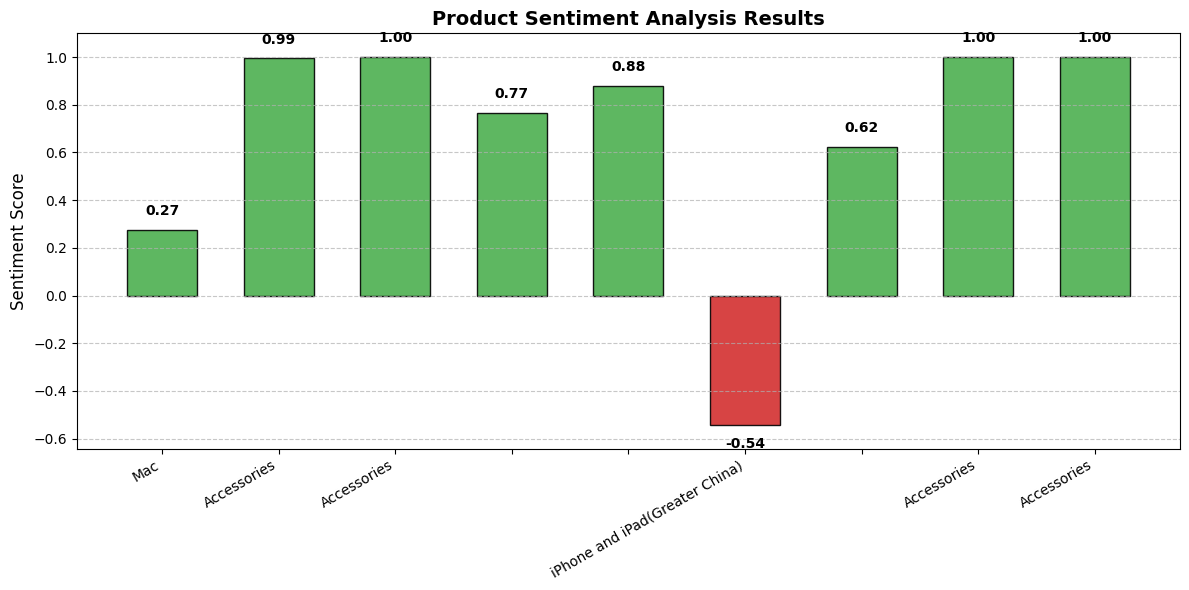

In [80]:
visualize_sentiments(sentiment_results)

In [81]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

In [82]:
# 配置参数
MODEL_NAME = "bert-base-uncased"  # 可替换为distilbert-base-uncased提高速度
MAX_LENGTH = 512                  # BERT最大序列长度
BATCH_SIZE = 4                    # 根据显存调整
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BERTAnalyzer:
    def __init__(self):
        self.tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        self.model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=1)
        self.model.to(DEVICE)
        self.model.eval()

    def _preprocess(self, text):
        """文本预处理与分块"""
        # 清理特殊字符
        clean_text = re.sub(r'[^\w\s.,!?]', '', text)
        # 按句子分割处理长文本
        sentences = re.split(r'(?<=[.!?]) +', clean_text)
        return [sent.strip() for sent in sentences if sent.strip()]

    def analyze(self, text):
        """执行情感分析"""
        chunks = self._preprocess(text)
        compound_scores = []
        
        with torch.no_grad():
            for i in range(0, len(chunks), BATCH_SIZE):
                batch = chunks[i:i+BATCH_SIZE]
                inputs = self.tokenizer(
                    batch,
                    padding=True,
                    truncation=True,
                    max_length=MAX_LENGTH,
                    return_tensors="pt"
                ).to(DEVICE)
                
                outputs = self.model(**inputs)
                batch_scores = torch.sigmoid(outputs.logits).cpu().numpy()
                compound_scores.extend(batch_scores[:, 0])  # 转换到[0,1]区间
        
        return np.mean(compound_scores) if compound_scores else 0

def process_pdf(pdf_path):
    """处理PDF文件主流程"""
    # 提取文本
    reader = PdfReader(pdf_path)
    full_text = "\n".join([page.extract_text() for page in reader.pages])
    
    # 分割产品段落
    product_sections = re.split(
        r'\n(?=\b(iPhone|Mac|iPad|Wearables)\b)', 
        full_text, 
        flags=re.IGNORECASE
    )
    
    # 初始化分析器
    analyzer = BERTAnalyzer()
    results = {}
    
    # 分析每个产品
    for i in range(1, len(product_sections), 2):
        product = product_sections[i].strip()
        content = product_sections[i+1]
        score = analyzer.analyze(content[:2000])  # 分析前2000字符
        results[product] = score
    
    return results

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT情感分析结果:
iPhone       → 0.3747
Mac          → 0.3477
iPad         → 0.3267
Wearables    → 0.3756


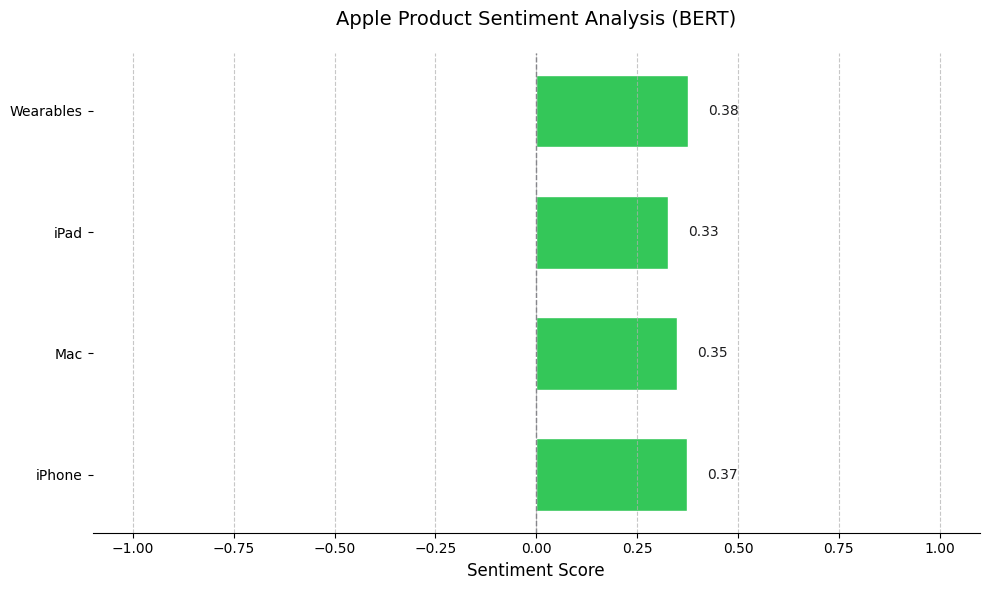

In [83]:
def visualize(results):
    """专业可视化"""
    products = list(results.keys())
    scores = list(results.values())
    
    plt.figure(figsize=(10, 6))
    colors = ['#34C759' if s > 0 else '#FF3B30' for s in scores]
    
    # 横向柱状图
    bars = plt.barh(products, scores, color=colors, edgecolor='white', height=0.6)
    
    # 图表美化
    plt.xlim(-1.1, 1.1)
    plt.axvline(0, color='#86868B', linestyle='--', lw=1)
    plt.title('Apple Product Sentiment Analysis (BERT)', fontsize=14, pad=20)
    plt.xlabel('Sentiment Score', fontsize=12)
    
    # 移除冗余元素
    plt.gca().spines[['top', 'right', 'left']].set_visible(False)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    
    # 添加数据标签
    for bar in bars:
        width = bar.get_width()
        label_x = width + 0.05 if width > 0 else width - 0.1
        plt.text(label_x, bar.get_y() + bar.get_height()/2, 
                f'{width:.2f}', 
                va='center', 
                color='white' if abs(width) > 0.5 else '#1D1D1F')
    
    plt.tight_layout()
    plt.savefig('bert_sentiment.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    pdf_path = "D:/rady/MGTF423/apple_10k_2024.pdf"
    results = process_pdf(pdf_path)
    print("BERT情感分析结果:")
    for product, score in results.items():
        print(f"{product:12} → {score:.4f}")
    visualize(results)